In [1]:
import cdsapi
import time


def request_era5_api(f_name, shape=None):
    fpath = f'data/download/{f_name}'
    if shape is None:
        area = [90, -180, -90, 180]
    else:
        west, sorth, east, north = shape.bounds
        area = [north, west, sorth, east]

    print('\n### ~~~~~~ ###')
    print('START requesting ERA5 API')
    start = time.time()

    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': '2023',
        'month': '01',
        'day': '05',
        'time': [
            '00:00',
            '01:00',
            '02:00',
            '03:00',
            '04:00',
            '05:00',
            '06:00',
            '07:00',
            '08:00',
            '09:00',
            '10:00',
            '11:00',
            '12:00',
            '13:00',
            '14:00',
            '15:00',
            '16:00',
            '17:00',
            '18:00',
            '19:00',
            '20:00',
            '21:00',
            '22:00',
            '23:00',
        ],
        'area': area,
    }, fpath)

    end = time.time()
    print(f'DONE requesting ERA5 API in {end - start} seconds')
    print('### ~~~~~~ ###\n')

    return fpath

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import folium


def shape_mask(fpath, shape):
    gdf_shape = gpd.GeoDataFrame(geometry=[shape], crs=4326)

    ds = xr.open_dataset(fpath)
    ds_2d = ds.isel(time=0)

    df_lat = pd.DataFrame(enumerate(ds_2d['latitude'].values), columns=['lat_index', 'latitude'])
    df_lon = pd.DataFrame(enumerate(ds_2d['longitude'].values), columns=['lon_index', 'longitude'])

    df_2d = ds_2d.to_dataframe()
    df_2d = df_2d.reset_index()
    df_2d = df_2d[['latitude', 'longitude', 't2m']]
    df_2d = df_2d.merge(df_lat, on='latitude')
    df_2d = df_2d.merge(df_lon, on='longitude')
    gdf_2d = gpd.GeoDataFrame(
        df_2d,
        geometry=gpd.points_from_xy(df_2d.longitude, df_2d.latitude),
        crs=4326,
    )
    gdf_masked = gdf_2d.sjoin(gdf_shape, how='inner', predicate="within")

    lat_index = gdf_masked['lat_index'].values
    lon_index = gdf_masked['lon_index'].values
    mask = np.zeros(ds_2d['t2m'].shape)
    mask[lat_index, lon_index] = 1
    mask = mask.astype(bool)

    m = gdf_shape.explore(name='shape', tiles='Stamen Terrain')
    gdf_2d.explore(m=m, column='t2m', name='api_request_points', cmap='Oranges')
    gdf_masked.explore(m=m, column='t2m', name='masked_points', cmap='Blues')
    folium.LayerControl().add_to(m)
    m.save('poc_a_map.html')
    return mask

In [3]:
import geopandas as gpd

gdf_tri = gpd.read_file('data/vector/greenland_main_island.geojson')
shape = gdf_tri.loc[0, 'geometry']
download_fpath = request_era5_api('poc_a.nc', shape)
print(download_fpath)
mask = shape_mask(download_fpath, shape)


### ~~~~~~ ###
START requesting ERA5 API


2023-07-11 11:43:50,696 INFO Welcome to the CDS
2023-07-11 11:43:50,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-11 11:43:50,907 INFO Request is completed
2023-07-11 11:43:50,909 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/adaptor.mars.internal-1689093330.3342187-10333-14-e3f17986-ec9e-42c7-a296-b89ca9e8264c.nc to data/download/poc_a.nc (1.1M)
2023-07-11 11:43:52,489 INFO Download rate 696.9K/s 


DONE requesting ERA5 API in 2.544928789138794 seconds
### ~~~~~~ ###

data/download/poc_a.nc


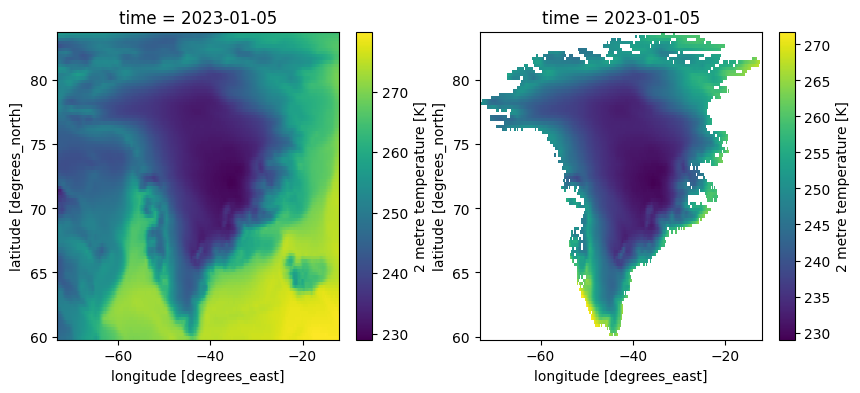

In [4]:
# working with xarray
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(download_fpath)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
xa_t0 = ds.isel(time=0)
xa_t0['t2m'].plot(ax=ax1)
xa_t0['t2m'].where(mask).plot(ax=ax2)

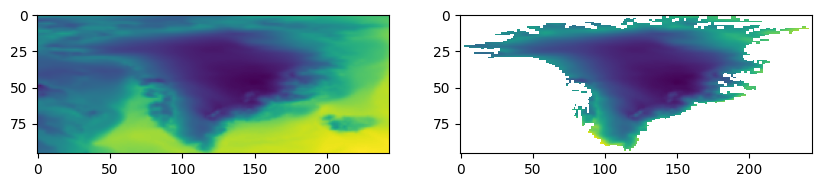

In [5]:
# working with netCDF4
import matplotlib.pyplot as plt
import netCDF4 as nc

ds = nc.Dataset(download_fpath)
ma_t0 = ds['t2m'][0, :, :]
ma_t0_masked = np.ma.masked_array(ma_t0, mask=~mask)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(ma_t0)
ax2.imshow(ma_t0_masked)